# BASELINE ML

Uruchamia jeden prosty model i wszystkie metryki zgodnie z Sprint 1

1. Wczytanie pełnego zbioru danych
2. Sprawdzenie skośności rozkładu (potwierdzenie dla MAE)
3. Dzielenie na zbiór testowy i treningowy
4. Uruchomienie modelu RandomForest na pełnym zbiorze
5. Obliczenie wszystkich metryk: MAE (główna), RMSE, R², MAPE
6. Analiza outlierów (Sprint 1)
7. Wizualizacja na pełnym zbiorze danych



In [1]:
# Import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Ustawienia
pd.set_option('display.max_columns', None)

print("Gotowe")

Gotowe


## 1. Wczytanie danych


In [2]:
# Wczytanie danych

df = pd.read_csv('../data/02_interim/wec_lap_data_cleaned.csv')
print(f"Wczytano dane: {df.shape[0]} wierszy, {df.shape[1]} kolumn")
print(f"Braki w danych: {df.isnull().sum().sum()}")


Wczytano dane: 501482 wierszy, 51 kolumn
Braki w danych: 0


## 2. Dzielenie na zbiór testowy i treningowy

In [3]:
# Przygotowanie zbioru do modelowania
# 1) Upewniam się, że jest lap_time_seconds
if 'lap_time_seconds' not in df.columns and 'lap_time' in df.columns:
    df['lap_time_seconds'] = pd.to_timedelta(df['lap_time'], errors='coerce').dt.total_seconds()

# 2) Upewniam się, że jest pit_time_seconds i braki=0
if 'pit_time_seconds' not in df.columns and 'pit_time' in df.columns:
    df['pit_time_seconds'] = pd.to_timedelta(df['pit_time'], errors='coerce').dt.total_seconds()
if 'pit_time_seconds' in df.columns:
    df['pit_time_seconds'] = df['pit_time_seconds'].fillna(0)

# 3) Używamy pełnego zbioru danych
df_model = df.copy()
print(f"Pełny zbiór do modelowania: {df_model.shape[0]} wierszy")

# 4) Sprawdzenie skośności rozkładu
if 'lap_time_seconds' in df_model.columns:
    skewness = df_model['lap_time_seconds'].skew(skipna=True)
    print(f"Skośność rozkładu lap_time_seconds: {skewness:.2f}")
    if abs(skewness) > 1:
        print("Potwierdzenie: rozkład jest silnie skośny - MAE jako główna metryka")

# 5) Target i cechy - TYLKO NUMERYCZNE (unikamy MemoryError)
assert 'lap_time_seconds' in df_model.columns, "Brak kolumny lap_time_seconds"
target_col = 'lap_time_seconds'
y = df_model[target_col]

# Wybierz TYLKO kolumny numeryczne
X = df_model.drop(columns=[target_col]).select_dtypes(include=['number'])
print(f"Wybrano {X.shape[1]} cech numerycznych")

# Braki -> 0
X = X.fillna(0)
if X.isnull().sum().sum() > 0:
    print(f"⚠️ Ostrzeżenie: {X.isnull().sum().sum()} braków po fillna(0)")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Pełny zbiór: {len(X_train) + len(X_test)} wierszy")

Pełny zbiór do modelowania: 501482 wierszy
Skośność rozkładu lap_time_seconds: 35.47
✓ Potwierdzenie: rozkład jest silnie skośny → MAE jako główna metryka (Sprint 1)
Wybrano 33 cech numerycznych
Train shape: (401185, 33), Test shape: (100297, 33)
Pełny zbiór: 501482 wierszy


## 3. Uruchomienie modelu

In [4]:
# Model bazowy
from sklearn.ensemble import RandomForestRegressor
import time

print(f"Start treningu RandomForest: próbki={X_train.shape[0]}, cechy={X_train.shape[1]}")
start_time = time.time()
model = RandomForestRegressor(
    random_state=42,
    n_estimators=100,
    n_jobs=-1,
    verbose=1  # wypisuje postęp trenowania drzew
)
model.fit(X_train, y_train)
elapsed = time.time() - start_time
print(f"Trening zakończony w {elapsed:.1f}s")

Start treningu RandomForest: próbki=401185, cechy=33


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   18.2s


Trening zakończony w 70.5s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


## 4. Obliczenie metryki

In [5]:
# Obliczenie wszystkich metryk (MAE, RMSE, R², MAPE)
y_pred = model.predict(X_test)

# Metryki
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("=" * 50)
print("METRYKI EWALUACJI (Sprint 1):")
print("=" * 50)
print(f"MAE (główna metryka): {mae:.4f} s")
print(f"RMSE:                {rmse:.4f} s")
print(f"R²:                  {r2:.4f}")
print(f"MAPE:                {mape:.2f}%")
print("=" * 50)
print(f"\nMAE jest główną metryką ze względu na silną skośność rozkładu (Sprint 1)")


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


METRYKI EWALUACJI (Sprint 1):
MAE (główna metryka): 0.0314 s
RMSE:                2.1977 s
R²:                  0.9998
MAPE:                0.00%

MAE jest główną metryką ze względu na silną skośność rozkładu (Sprint 1)


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished


## 5. Wizualizacja

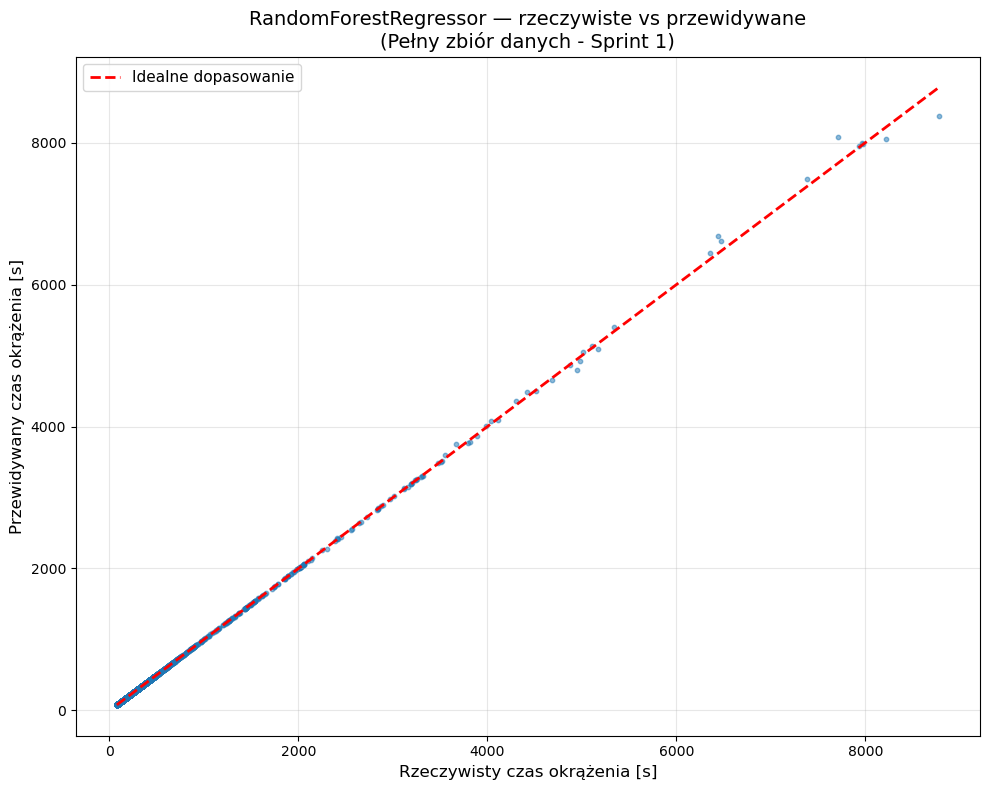

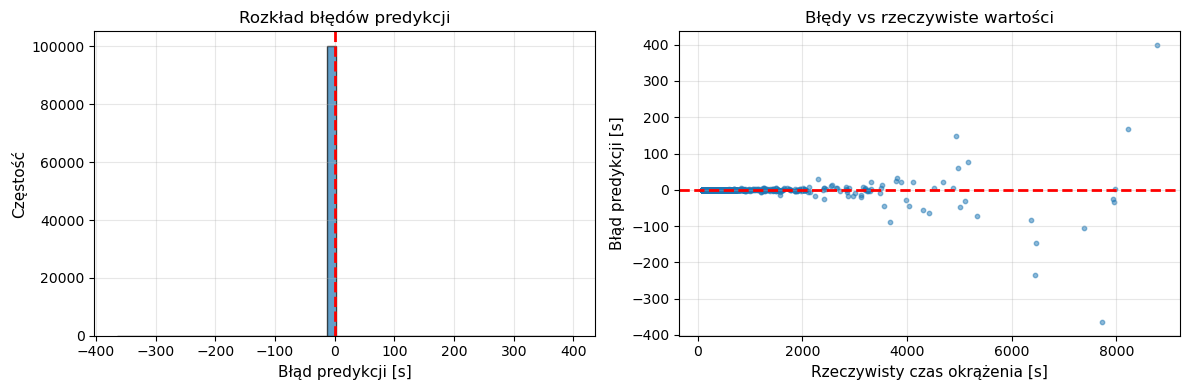

Statystyki błędów:
  Średni błąd: -0.0053 s
  Mediana błędu: 0.0000 s
  Std błędu: 2.1977 s


In [6]:
# Wizualizacja: rzeczywiste vs. przewidywane
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(y_test, y_pred, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Idealne dopasowanie', linewidth=2)
plt.xlabel("Rzeczywisty czas okrążenia [s]", fontsize=12)
plt.ylabel("Przewidywany czas okrążenia [s]", fontsize=12)
plt.title("RandomForestRegressor — rzeczywiste vs przewidywane\n(Pełny zbiór danych - Sprint 1)", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Dodatkowa analiza: rozkład błędów
errors = y_test - y_pred
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Błąd predykcji [s]', fontsize=11)
plt.ylabel('Częstość', fontsize=11)
plt.title('Rozkład błędów predykcji', fontsize=12)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, errors, alpha=0.5, s=10)
plt.xlabel('Rzeczywisty czas okrążenia [s]', fontsize=11)
plt.ylabel('Błąd predykcji [s]', fontsize=11)
plt.title('Błędy vs rzeczywiste wartości', fontsize=12)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Statystyki błędów:")
print(f"  Średni błąd: {errors.mean():.4f} s")
print(f"  Mediana błędu: {errors.median():.4f} s")
print(f"  Std błędu: {errors.std():.4f} s")

ANALIZA OUTLIERÓW:
Liczba outlierów: 8897 (1.77%)
Zakres normalny: [-55.99, 398.11] s
Min outlier: 398.13 s
Max outlier: 20641.57 s

Outliery z pit stopami: 2355 (26.5% outlierów)


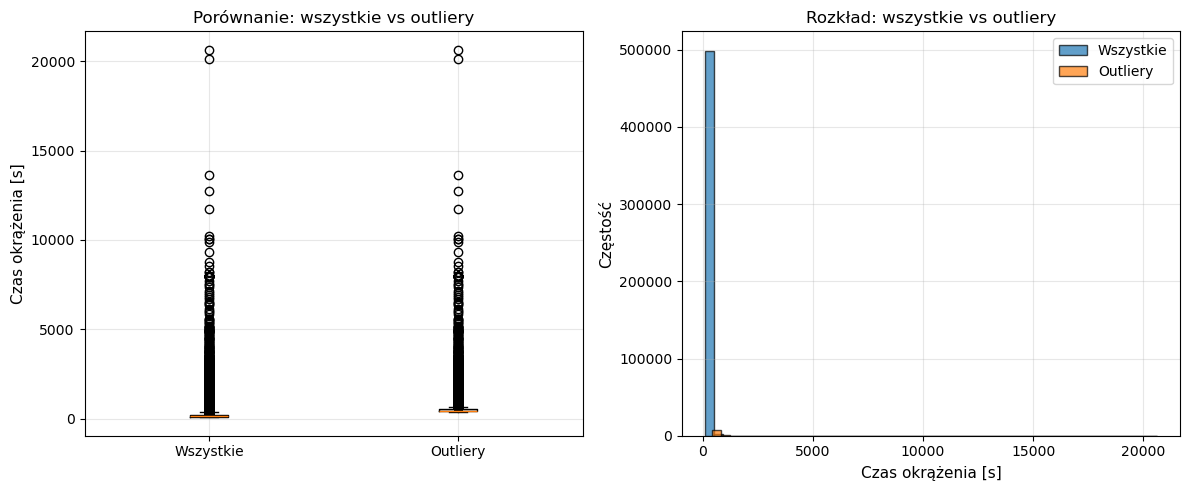

In [7]:
# Analiza outlierów w czasach okrążeń
if 'lap_time_seconds' in df_model.columns:
    Q1 = df_model['lap_time_seconds'].quantile(0.25)
    Q3 = df_model['lap_time_seconds'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_model[(df_model['lap_time_seconds'] < lower_bound) | 
                        (df_model['lap_time_seconds'] > upper_bound)]
    
    print("=" * 50)
    print("ANALIZA OUTLIERÓW:")
    print("=" * 50)
    print(f"Liczba outlierów: {len(outliers)} ({len(outliers)/len(df_model)*100:.2f}%)")
    print(f"Zakres normalny: [{lower_bound:.2f}, {upper_bound:.2f}] s")
    print(f"Min outlier: {outliers['lap_time_seconds'].min():.2f} s")
    print(f"Max outlier: {outliers['lap_time_seconds'].max():.2f} s")
    
    # Sprawdź czy outliery to pit stopy
    if 'pit_time_seconds' in df_model.columns:
        pit_outliers = outliers[outliers['pit_time_seconds'] > 0]
        print(f"\nOutliery z pit stopami: {len(pit_outliers)} ({len(pit_outliers)/len(outliers)*100:.1f}% outlierów)")
        if len(pit_outliers) / len(outliers) > 0.5:
            print("Wniosek: Większość outlierów to pit stopy")

    # Wizualizacja outlierów
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.boxplot([df_model['lap_time_seconds'], outliers['lap_time_seconds']], 
                labels=['Wszystkie', 'Outliery'])
    plt.ylabel('Czas okrążenia [s]', fontsize=11)
    plt.title('Porównanie: wszystkie vs outliery', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(df_model['lap_time_seconds'], bins=50, alpha=0.7, label='Wszystkie', edgecolor='black')
    plt.hist(outliers['lap_time_seconds'], bins=50, alpha=0.7, label='Outliery', edgecolor='black')
    plt.xlabel('Czas okrążenia [s]', fontsize=11)
    plt.ylabel('Częstość', fontsize=11)
    plt.title('Rozkład: wszystkie vs outliery', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

